In [177]:
import tensorflow as tf
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Data Preparation

In [178]:
df = pd.read_csv("/notebooks/Text-Multiclass-Classification/data_input/770 Whole Thread LabelledU.csv", index_col=0)
df = df[['clean_text', 'Dominant Label']]
df.head()

,clean_text,Dominant Label
Count,,
0,module transfer module leader module copy co...,VLE and Module
1,compromise manatee might send add...,Unclassifiable
2,reassign setup rove mikes room lib opsbusadm...,Hardware and Room
3,conference facilities room next wednesday b...,Hardware and Room
4,room seem lack function mfd room scan usb ...,Hardware and Room


### Remove row labeled : ['unclassifiable', 'None', and 'Network and database']

In [179]:
df["Dominant Label"].value_counts()

Software and Access     271
VLE and Module          204
Hardware and Room       150
Mail                     47
Account and Password     40
Unclassifiable           30
Network and Database     25
None                      2
Name: Dominant Label, dtype: int64

In [180]:
unclassifiable_mask = (df['Dominant Label'] != 'Unclassifiable')
none_mask = (df['Dominant Label'] != 'None')
network_database_mask = (df['Dominant Label'] != 'Network and Database')

In [181]:
df = df[unclassifiable_mask & none_mask & network_database_mask]
df['Dominant Label'].value_counts()

Software and Access     271
VLE and Module          204
Hardware and Room       150
Mail                     47
Account and Password     40
Name: Dominant Label, dtype: int64

In [182]:
label = df['Dominant Label'].unique()

In [183]:
# Encode the Dominant Label to integer value

df['Dominant Label'] = df['Dominant Label'].map({'VLE and Module' : 0,
                                                 'Hardware and Room' : 1,
                                                 'Mail' : 2,
                                                 'Software and Access' : 3,
                                                 'Account and Password' : 4 })                                         

# it's oke if we got Warning after running this code

### Handle Missing and Duplicate data

In [184]:
# Detect missing values
# isna() will check column if there is Nan, null, or na data it will return True  if not then False
# Since True = 1 and False = 0. when we sum together each True and False then we will know how many missing values is
df.isna().sum()

clean_text        0
Dominant Label    0
dtype: int64

In [185]:
True + True + True

3

In [186]:
# Detect Duplicate data

df[df.duplicated(keep = False)]

# df.duplicated when we set keep = False : Mark all duplicates as True.

,clean_text,Dominant Label
Count,,
91,add mail address brl mail list colleague add...,2
95,add mail address brl mail list colleague add...,2
102,add mail address brl mail list colleague add...,2


In [187]:
# Remove the duplicates data
df = df.drop_duplicates()

In [188]:
df

,clean_text,Dominant Label
Count,,
0,module transfer module leader module copy co...,0
2,reassign setup rove mikes room lib opsbusadm...,1
3,conference facilities room next wednesday b...,1
4,room seem lack function mfd room scan usb ...,1
5,phone frustrate polycom phone sign skype wont...,1
...,...,...
764,authenticator failure sign anything microso...,2
765,password password way reset apparently reg...,1
766,phone line student support line support phon...,3


In [189]:
X, y = df['clean_text'], df['Dominant Label']

### Train Test Split



In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state=12431)

### Preprocessing Data

 ####  Tokenizer

##### Example Of Tokenizer

In [191]:
example_train_sentence = ['the film is so cool wow', 'the film is not interesting']
example_test_sentence = ['the film is dissapointing']

In [192]:
# num_words = 2, mean Tokenizer will take the top 2 words by volume 
# usually minimum num_words will give  huge training time and less training acc 
example_num_words = 2

#oov_token = "<OOV>" mean Out Of Vocabulary, since the test data is getting token by fitted train data then there is probability, 
#the word in test data is not recognize by the tokenizer then tokenizer will encode it as <OOV>
example_oov_token = "OOV"

example_tokenizer = Tokenizer(num_words = example_num_words, oov_token = example_oov_token)

In [193]:
example_tokenizer.fit_on_texts(example_train_sentence)

In [194]:
example_tokenizer.word_index

{'OOV': 1,
 'the': 2,
 'film': 3,
 'is': 4,
 'so': 5,
 'cool': 6,
 'wow': 7,
 'not': 8,
 'interesting': 9}

In [195]:
example_tokenizer.word_counts

OrderedDict([('the', 2),
             ('film', 2),
             ('is', 2),
             ('so', 1),
             ('cool', 1),
             ('wow', 1),
             ('not', 1),
             ('interesting', 1)])

In [196]:
example_X_train_sequences = example_tokenizer.texts_to_sequences(example_train_sentence)
print("train sequences : {}".format(example_X_train_sequences))


example_X_test_sequences = example_tokenizer.texts_to_sequences(example_test_sentence)
print("test sequences : {}".format(example_X_test_sequences))


train sequences : [[1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1]]
test sequences : [[1, 1, 1, 1]]


💡 we can see all test text is encoded to 1, or if we see on the index as OOV. it's because we set num_words = 2 when define the Tokenizer

💡 why only encoded to 1 isn't word <b>'the'</b> should be encoded to <b>2</b> also ?

💡 according to the documentation, it will take Only the most common num_words-1 words will be kept<br>
Docs : https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

💡 so if we want encoding the word "the" also. then we need to set the num_words = 3

##### The Tokenizer will be used

In [197]:
# currently im not define the num_words, so it will take all words on all the training text.
oov_token = "<OOV>"
tokenizer = Tokenizer(oov_token=oov_token)

tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [198]:
# although we didn't define num_words before defining the tokenizer class. we still need num_words as dimmer input from Embedding layer later
num_words = len(tokenizer.word_index) + 1
num_words

4528

💡  always + 1 because tokenizer.word_index not include 0 value

#### Padding

##### Example of Padding

💡  the default pad_sequences function

tf.keras.utils.pad_sequences(<br>
    sequences,<br>
    maxlen=None,<br>
    dtype='int32',<br>
    padding='pre',<br>
    truncating='pre',<br>
    value=0.0
)
<br>
<br>
docs : https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences


💡  our example sequences data <br>
example X_train_sequences : [[1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1]] <br>
example X_test_sequences : [[1, 1, 1, 1]]

In [199]:
# let say we not define maxlen
# if maxlen not defined then all the texts will padded follow the length of most word in the texts
# if the length of word in a text < maxlen we define then it will padding
# if the length of word in a text > maxlen we define then it will truncating

example_X_train_padded = pad_sequences(example_X_train_sequences)
example_X_test_padded = pad_sequences(example_X_test_sequences)

print(example_X_train_padded)

[[1 1 1 1 1 1]
 [0 1 1 1 1 1]]


💡 we can see, the text 2 is padded with 0 because follow the length of most word in the texts

💡 because the default padding='pre' so it will do 'pre' padding. it can be changed to "post"

##### The Padding will be used

In [200]:
list_of_train_sequence_length = []
list_of_test_sequence_length = []

# let see what maximum number of words on a train text data we can found
for sequence in X_train_sequences :
    list_of_train_sequence_length.append(len(sequence))

for sequence in X_test_sequences :
    list_of_test_sequence_length.append(len(sequence))

print("maximum length of sequence in train data is : {}".format(max(list_of_train_sequence_length)))
print("maximum length of sequence in test data is : {}".format(max(list_of_test_sequence_length)))

maximum length of sequence in train data is : 1057
maximum length of sequence in test data is : 744


In [201]:
# Generate and pad the training sequences
maxlen = 150
padding = "post"
truncating = "post"

X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding=padding, truncating=truncating)
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen, padding=padding, truncating = truncating)

💡 we need to make the train and test in same shape, so we need define the maxlen

In [202]:
# Convert the labels lists into numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

## Modeling

💡 Overfitting naturally occurs in NLP. it's because the OOV Token found on the test data can't be classified

💡  The target of this modeling is try to get model with smoother decreased loss/ stable loss. so even model still Overfitting we have conviction to the model

### Always start with embedding first

In [203]:
embedding_dim = 16

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words , embedding_dim, input_length = maxlen),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

# Print the model summary
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 150, 16)           72448     
                                                                 
 flatten_7 (Flatten)         (None, 2400)              0         
                                                                 
 dense_20 (Dense)            (None, 16)                38416     
                                                                 
 dense_21 (Dense)            (None, 5)                 85        
                                                                 
Total params: 110,949
Trainable params: 110,949
Non-trainable params: 0
_________________________________________________________________


💡 Embedding : Embed all word in similiar class in a vector.<br>
example : we say a negative review and the words dull and boring show up a lot in the negative review so that they have similar sentiments, and they are close to each other in the sentence. Thus their vectors will be similar.

💡 Flatten : since the output of the embedding is (batch size, maxlen, embedding_dim) we need to flatten its output to (batch_size, maxlen * embedding_dim) since the dense take that shape of input.

💡 usually we can change flatten -> GlobalPoolingAverage.
it will convert the output of our embedding (batch size, maxlen, embedding_dim) -> (batch size, average of maxlen each of embedding dimension)

advantage :
More Faster

deficiency:
reduced accuracy

💡 The Output of Flatten layer until last layers in the model above usually called Fully Connected Layer / Neural Network <br>
💡 The Output of Flatten called Input Layer <br>
💡 The next layer after Flattern layer called hidden layer <br>
💡 The last layer called Output layer 

💡 usually hidden layer can be stacked as many as needed. but usually 2 hidden layer is enough to solve complex problem <br>
💡 Why we define 64 as the num_of_dense in the hidden layer ? its free actualy but usually in Fully connected layer people define it conical. so if the first hidden layer is 64 then the next hidden layer will be 32. <br>
💡 Why we define "Relu" as the activation function of Hidden layer ? it's because Relu output is 0 until Infinity. it's same like our sequences data which is if you see on the sequences, our data value minimum is  0 (result of padding), 1 (OOV), ...., num_words we define

💡 Output layers is customized. <br>
💡 Since we want to classify 5 class then we need define the num_dense of last layers is 5. <br>
💡 if we want to classify 2 class then 1 dense <br>
💡 Softmax is used for multiclass <br>
💡 Sigmoid is used for binary class (2 class)

In [204]:
# Compile the modeld
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

💡 Don't forget to always Compile the model before training.

💡 loss : sparse_categorical_cross_entropy is used because our label using integer value (0 to 4) <br>
💡 we can use "categorical_crossentropy" if our label is encoded with one hot encoding <br>
💡 adam optimizer is the best optimizer currently : https://towardsdatascience.com/optimizers-for-training-neural-network-59450d71caf6

In [205]:
num_epochs = 50
# Train the model
history_embedding = model.fit(X_train_padded, y_train, epochs=num_epochs, validation_data=(X_test_padded, y_test))
%time

Epoch 1/50
18/18 [==============================] - 1s 15ms/step - loss: 1.5770 - accuracy: 0.3011 - val_loss: 1.5739 - val_accuracy: 0.2254
Epoch 2/50
18/18 [==============================] - 0s 7ms/step - loss: 1.4581 - accuracy: 0.3451 - val_loss: 1.5187 - val_accuracy: 0.2183
Epoch 3/50
18/18 [==============================] - 0s 7ms/step - loss: 1.3175 - accuracy: 0.4155 - val_loss: 1.4340 - val_accuracy: 0.2676
Epoch 4/50
18/18 [==============================] - 0s 5ms/step - loss: 1.1609 - accuracy: 0.5528 - val_loss: 1.3382 - val_accuracy: 0.3873
Epoch 5/50
18/18 [==============================] - 0s 6ms/step - loss: 0.9806 - accuracy: 0.7412 - val_loss: 1.2740 - val_accuracy: 0.4577
Epoch 6/50
18/18 [==============================] - 0s 6ms/step - loss: 0.7803 - accuracy: 0.8222 - val_loss: 1.2234 - val_accuracy: 0.5211
Epoch 7/50
18/18 [==============================] - 0s 6ms/step - loss: 0.5789 - accuracy: 0.8891 - val_loss: 1.1392 - val_accuracy: 0.5563
Epoch 8/50
18/18 [=

#### Evaluation

In [206]:
import matplotlib.pyplot as plt


def plot_graphs(history, string, model_name):
  plt.title('Training and validation {} of {}'.format(string,model_name))
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

##### Accuracy

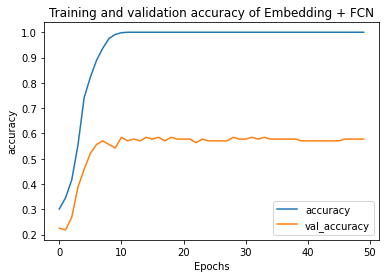

In [207]:
plot_graphs(history_embedding, "accuracy", "Embedding + FCN")

##### Loss

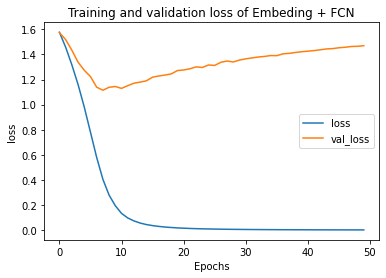

In [208]:
plot_graphs(history_embedding, "loss", "Embeding + FCN")

##### Classification Report

In [209]:
y_pred = model.predict(X_test_padded)
y_pred = np.argmax(y_pred,axis=1)
print(classification_report(y_test, y_pred, target_names= label))

5/5 [==============================] - 0s 2ms/step
                      precision    recall  f1-score   support

      VLE and Module       0.59      0.71      0.65        31
   Hardware and Room       0.75      0.43      0.55        42
                Mail       0.33      0.09      0.14        11
 Software and Access       0.51      0.75      0.61        51
Account and Password       0.75      0.43      0.55         7

            accuracy                           0.58       142
           macro avg       0.59      0.48      0.50       142
        weighted avg       0.60      0.58      0.56       142



💡 usually combine Embeding with Conv1D can gain more Accuracy

### Increasing Accuracy : Adding Conv1D

In [210]:
embedding_dim = 16

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words , embedding_dim, input_length = maxlen),
    tf.keras.layers.Conv1D(16, 2),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

# Compile the modeld
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 150, 16)           72448     
                                                                 
 conv1d_7 (Conv1D)           (None, 149, 16)           528       
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 74, 16)           0         
 1D)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 1184)              0         
                                                                 
 dense_22 (Dense)            (None, 16)                18960     
                                                                 
 dense_23 (Dense)            (None, 5)                 85        
                                                     

In [211]:
num_epochs = 50

# Train the model
history_embed_conv = model.fit(X_train_padded, y_train, epochs=num_epochs, validation_data=(X_test_padded, y_test))
%time

Epoch 1/50
18/18 [==============================] - 1s 15ms/step - loss: 1.5137 - accuracy: 0.3715 - val_loss: 1.4502 - val_accuracy: 0.3592
Epoch 2/50
18/18 [==============================] - 0s 7ms/step - loss: 1.3451 - accuracy: 0.3873 - val_loss: 1.4357 - val_accuracy: 0.3310
Epoch 3/50
18/18 [==============================] - 0s 6ms/step - loss: 1.2849 - accuracy: 0.4313 - val_loss: 1.4290 - val_accuracy: 0.3380
Epoch 4/50
18/18 [==============================] - 0s 7ms/step - loss: 1.2015 - accuracy: 0.4560 - val_loss: 1.3856 - val_accuracy: 0.3451
Epoch 5/50
18/18 [==============================] - 0s 7ms/step - loss: 1.0805 - accuracy: 0.5528 - val_loss: 1.3192 - val_accuracy: 0.4366
Epoch 6/50
18/18 [==============================] - 0s 7ms/step - loss: 0.9050 - accuracy: 0.7060 - val_loss: 1.2365 - val_accuracy: 0.5070
Epoch 7/50
18/18 [==============================] - 0s 7ms/step - loss: 0.7243 - accuracy: 0.7835 - val_loss: 1.1947 - val_accuracy: 0.5282
Epoch 8/50
18/18 [=

#### Evaluation

##### Accuracy

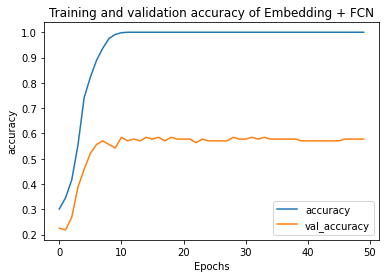

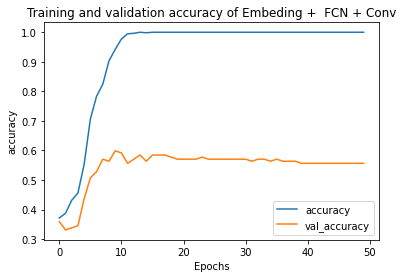

In [212]:
plot_graphs(history_embedding, "accuracy", "Embedding + FCN")
plot_graphs(history_embed_conv,"accuracy", "Embeding +  FCN + Conv")

##### Loss

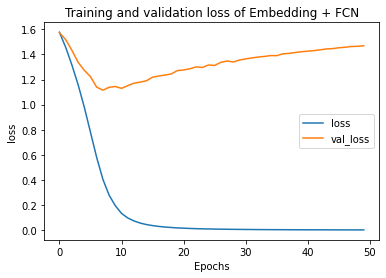

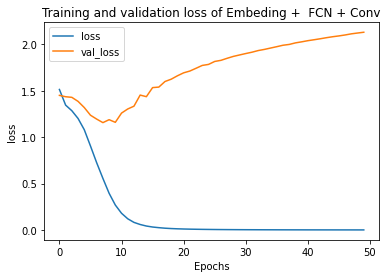

In [213]:
plot_graphs(history_embedding, "loss", "Embedding + FCN")
plot_graphs(history_embed_conv,"loss", "Embeding +  FCN + Conv")

##### Classification Report

In [214]:
y_pred = model.predict(X_test_padded)
y_pred = np.argmax(y_pred,axis=1)
print(classification_report(y_test, y_pred, target_names= label))

5/5 [==============================] - 0s 2ms/step
                      precision    recall  f1-score   support

      VLE and Module       0.50      0.74      0.60        31
   Hardware and Room       0.65      0.52      0.58        42
                Mail       1.00      0.18      0.31        11
 Software and Access       0.55      0.59      0.57        51
Account and Password       0.40      0.29      0.33         7

            accuracy                           0.56       142
           macro avg       0.62      0.46      0.48       142
        weighted avg       0.59      0.56      0.55       142



💡 our model getting better on accuracy but we still can't have conviction to the model since the loss getting worst <br>
💡 usually adding LSTM will make the loss more stable even decreasing <br>

### Stabling the loss of the Model : Adding LSTM

💡 usually LSTM used to make the loss more stable even decrease

💡 usually people using Bidirectional LSTM rather than normal one

💡 advantage Bidirectional than normal LSTM :<br>
* more faster train data <br>
* more better on fit (avoid overfitting) <br>
<br>
deficiency : <br>
*  need entire sentence to do the prediction. 

💡 below is how to build single Bidirectional <br>

In [215]:
# Ctrl + A and then Ctrl + / to uncomment this cell
# # embedding_dim = 16

# # Build the model
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(num_words , embedding_dim, input_length = maxlen),
#     tf.keras.layers.Conv1D(16, 4),
#     tf.keras.layers.MaxPooling1D(),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
#     tf.keras.layers.Dense(16, activation='relu'),
#     tf.keras.layers.Dense(5, activation='softmax')
# ])

# # Compile the modeld
# model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# # Print the model summary
# model.summary()

💡 below is how to build stacked Bidirectional <br>

In [216]:
embedding_dim = 16

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words , embedding_dim, input_length = maxlen),
    tf.keras.layers.Conv1D(16, 2),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

# Compile the modeld
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 150, 16)           72448     
                                                                 
 conv1d_8 (Conv1D)           (None, 149, 16)           528       
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 74, 16)           0         
 1D)                                                             
                                                                 
 bidirectional_6 (Bidirectio  (None, 74, 32)           4224      
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 16)               2624      
 nal)                                                            
                                                     

💡 to build normal LSTM simply remove tf.keras.layers.Bidirectional <br>
so  if you want build stacked normal LSTM the Bidirectional LSTM layers should be : <br>
<b> tf.keras.layers.LSTM(16, return_sequences = True),<b><br>
<b>tf.keras.layers.LSTM(8),<b><br>

In [217]:
num_epochs = 50

# Train the model
history_adding_lstm = model.fit(X_train_padded, y_train, epochs=num_epochs, validation_data=(X_test_padded, y_test))
%time

Epoch 1/50
18/18 [==============================] - 9s 136ms/step - loss: 1.5730 - accuracy: 0.3697 - val_loss: 1.5100 - val_accuracy: 0.3592
Epoch 2/50
18/18 [==============================] - 0s 25ms/step - loss: 1.4367 - accuracy: 0.3873 - val_loss: 1.4287 - val_accuracy: 0.3592
Epoch 3/50
18/18 [==============================] - 0s 24ms/step - loss: 1.3753 - accuracy: 0.3873 - val_loss: 1.4369 - val_accuracy: 0.3592
Epoch 4/50
18/18 [==============================] - 0s 24ms/step - loss: 1.3408 - accuracy: 0.3944 - val_loss: 1.4027 - val_accuracy: 0.3732
Epoch 5/50
18/18 [==============================] - 0s 25ms/step - loss: 1.2318 - accuracy: 0.5563 - val_loss: 1.3198 - val_accuracy: 0.4577
Epoch 6/50
18/18 [==============================] - 0s 24ms/step - loss: 1.0788 - accuracy: 0.6109 - val_loss: 1.2818 - val_accuracy: 0.4718
Epoch 7/50
18/18 [==============================] - 0s 25ms/step - loss: 0.9422 - accuracy: 0.6426 - val_loss: 1.2676 - val_accuracy: 0.4507
Epoch 8/50
1

#### Evaluation

##### Accuracy

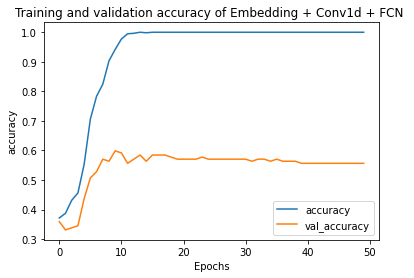

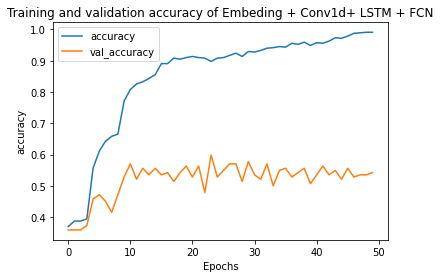

In [218]:
plot_graphs(history_embed_conv, "accuracy", "Embedding + Conv1d + FCN ")
plot_graphs(history_adding_lstm,"accuracy", "Embeding + Conv1d+ LSTM + FCN")

##### Loss

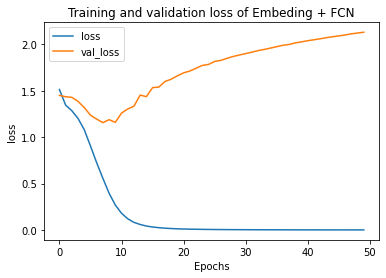

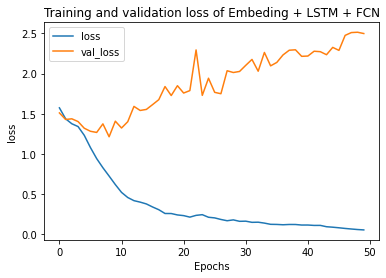

In [219]:
plot_graphs(history_embed_conv, "loss", "Embeding + FCN")
plot_graphs(history_adding_lstm,"loss", "Embeding + LSTM + FCN")

##### Classification Report

In [220]:
y_pred = model.predict(X_test_padded)
y_pred = np.argmax(y_pred,axis=1)
print(classification_report(y_test, y_pred, target_names= label))

5/5 [==============================] - 3s 9ms/step
                      precision    recall  f1-score   support

      VLE and Module       0.52      0.48      0.50        31
   Hardware and Room       0.67      0.62      0.64        42
                Mail       0.21      0.27      0.24        11
 Software and Access       0.56      0.65      0.60        51
Account and Password       0.00      0.00      0.00         7

            accuracy                           0.54       142
           macro avg       0.39      0.40      0.40       142
        weighted avg       0.53      0.54      0.53       142



💡 the loss should be better after added LSTM, but because we just have 710 row and 20% of it (142) row only is used as test and the test is too lame we can see on classification report above that Mail only have 11 data as test and account account and Password only 7 row meanwhile other data have 24+ (3 time larger than mail data) it very affect the lost.

## Testing data

In [232]:
testing_texts = ["I buy laptop when VGA price going up and it stuck my head since the VGA getting low and low","I buy laptop when VGA price going up and it stuck my head since the VGA getting low and low"]
testing_texts_sequences = tokenizer.texts_to_sequences(testing_texts)
testing_texts_sequences_padded = pad_sequences(testing_texts_sequences, maxlen=maxlen, padding=padding, truncating=truncating)

In [233]:
label

array(['VLE and Module', 'Hardware and Room', 'Mail',
       'Software and Access', 'Account and Password'], dtype=object)

In [234]:
predictions_proba = model.predict(testing_texts_sequences_padded)

1/1 [==============================] - 0s 29ms/step


In [235]:
for i in range(len(testing_texts)) :
    print("Text {} is labeled as {} \n".format(i+1, label[np.argmax(predictions_proba[i])]))
    print("Proba each label are : ")
    for label_i in range(len(label)):
        print(" {} probability is : {}".format(label[label_i], predictions_proba[i][label_i])) 
    print("=================================================================")

Text 1 is labeled as Mail 

Proba each label are : 
 VLE and Module probability is : 0.047631487250328064
 Hardware and Room probability is : 0.01829843409359455
 Mail probability is : 0.8357850313186646
 Software and Access probability is : 0.0009804784785956144
 Account and Password probability is : 0.09730460494756699
Text 2 is labeled as Mail 

Proba each label are : 
 VLE and Module probability is : 0.047631487250328064
 Hardware and Room probability is : 0.01829843409359455
 Mail probability is : 0.8357850313186646
 Software and Access probability is : 0.0009804784785956144
 Account and Password probability is : 0.09730460494756699


## Resume, Tips and Trick (don't have to follow)

1. Don't set the num_words of the Tokenizer so u will get all words in all sentence as the vocab <br>
2. if you build stacked CNN, example first CNN is 8 filters so the second CNN should be 16 the third is 32 and so on <br>
3. if you build stacked RNN, example first CNN is 16 units, the second RNN should be 8 units <br>
4. if you build stacked hidden layer, example first layer is 16 then the second should be 8